# Finding Molecules

This has become something of a "hello world" example for me when brushing up on a language. There's an example of doing this in *R* on [my website](https://bobturneruk.github.io/Finding_Molecules.nb.html). However, this goes a bit further as there was an opportunity to fairly straightforwardly link the problem of getting the rough locations of the parts of the image that represent light from single molecules and the next stage which is to fit a 2D Gaussian function for a better estimate of location ([see this seperate *R* example](https://bobturneruk.github.io/2D_Gaussian.nb.html)).

## Objective

Re-iterated from my *R* post:

*When reconstructing super resolved images from multiple frames of image data using single molecule localisation microscopy (e.g. PALM, STORM), the first challenge is often to locate regions of the frames where we expect to find images of molecules such that they can then be fitted to a model to determine their location. In this coding note, I’m going to go through the process of doing this. Several alterative approaches are available for many of the steps - this may not be how a particular piece of software e.g. NSTORM or ThunderSTORM tackles the problem, but it hopefully gives a general idea as to what’s going on under the hood.*

## Libraries
Job one is to import all of the libraries I need to do this. I've made use of the fitting in *astropy* to quickly get to the molecule locations.

In [1]:
import skimage
from skimage import io, exposure, feature, morphology, measure

import numpy as np

import matplotlib
from matplotlib import pyplot, patches

import astropy.modeling
from astropy.modeling import models, fitting

import pandas as pd

## Loading the image
Next, I load an image, again from [EPFL’s Single Molecule Microscopy Software Benchmarking site](http://bigwww.epfl.ch/smlm/challenge2013/datasets/Tubulins_I/index.html).

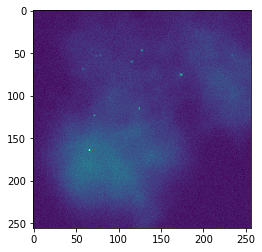

In [2]:
image=io.imread("00001.tif")
pyplot.imshow(image)

## Get rough locations of molecules
The next job is to obatain the rough locations of the molecules by finding "blobs" of the right size in the image. A lot more of this is taken care of by *skimage* here than by *imager* in *R*. In fact, the *blob_log* function does the filtering, thresholding and local maxima detection in a one-er. I've forced it to look only for blobs of a certain size. Generally one might want to look for lots of different sized blobs, so that's what the function is made to do, but here blob size is a signature of the point spread function of the microscope so large or small blobs should be ignored as they're not what we're looking for!

In [3]:
image_eq=exposure.equalize_adapthist(image) #This helps with the blob_log function
blobs=feature.blob_log(image_eq,threshold=0.04,min_sigma=2,max_sigma=2) #look only for blobs with a sigma (width) around 2 pixels

## Mark regions around blobs for curve fitting
The next block of code draws a square around each blob. Each of which is a region of interest that we will cut out and fit a Gaussian to.

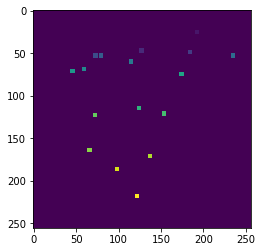

In [4]:
square_side=5 #length of one axis of the squre in pixels
blobs_image=np.zeros(image.shape) #an empty image the same size as our source image
blobs_image[blobs[:,0].astype(int),blobs[:,1].astype(int)]=1 #add blob locations to image
dilation_kernel=np.ones([square_side,square_side])
blobs_image_dilated=morphology.binary_dilation(blobs_image,dilation_kernel) #draw squares around blob locations
squares_labelled=measure.label(blobs_image_dilated) # label squares
pyplot.imshow(squares_labelled)

## Fit Gaussians
Now, as *astropy* presents the opportunity to do so easily, we can iterate trhough each of the squares and fit 2D Gaussians. The location of the peak of the Gaussian is the super-resolved location of the molecule we're interested in. Not sure if I'm using the most *pythonic* ways of array and list manipulation, here. I'd be happy to hear if there's a better way!

In [5]:
fitter = fitting.LevMarLSQFitter()

mols_x=[]
mols_y=[]

# iterate through square regions
for idx, region in enumerate(measure.regionprops(squares_labelled,image)):
    # check regions have not run together
    if region.area==square_side**2:
        # get region as x, y and z coordinates
        x,y=np.hsplit(region.coords,2)
        x=x.flatten()
        y=y.flatten()
        z=region.intensity_image.ravel()
        # fit gaussian
        g2d_init = models.Gaussian2D(x_mean=region.centroid[0],y_mean=region.centroid[1],fixed={"theta":True})
        p = fitter(g2d_init, x, y, z)
        mols_x.append(p.x_mean.value)
        mols_y.append(p.y_mean.value)

Here's a list of where we estiamte the molecules are:

In [6]:
pd.DataFrame({"x position (px)":mols_x,"y position (px)":mols_y})

,x position (px),y position (px)
0,25.443078,191.768629
1,46.790793,127.317003
2,48.713494,184.761979
3,53.243578,73.243685
4,52.937633,78.861268
5,53.323654,233.974313
6,60.151362,115.055455
7,68.809530,58.966458
8,71.161152,46.494716
9,75.095938,173.706491


And a plot of locations:

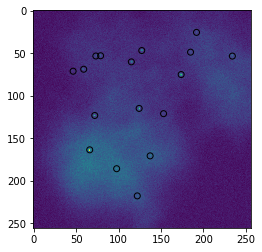

In [7]:
pyplot.imshow(image)
pyplot.scatter(mols_y,mols_x,facecolors="none",edgecolors="black")

## Summary
I've not found this too painful, despite being a bit of a *python* newbie. Hopefully it's useful to illustrate what's going on in localisation microscopy software and might form the basis of a straightforward *python* implementation of the technology.

See my [website](https://sites.google.com/view/robert-turner/code) for more examples. Contact me on bob dot turner dot uk at gmail dot com with comments or questions.